# Code For Model Output Analysis

Imports

In [46]:
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.model_diagnostics import ModelDiagnostics

Specifiy the paths to the nueral network config file you used to help train the model, as well as to whereever your validation dataset is.

In SPCAM5 data, it is 2 degree resolution, thus 96 latitudes and 144 longitudes. Also make this change in cbrain.model_diagnostics (line 18), where before it was 64 latitudes and 128 longitudes in SPCAM3

In [47]:
config_path = 'nn_config/precip_predict.yml'
validation_path = '/fast/gmooers/Preprocessed_Data/Very_Small_data/000_valid.nc'
lats = 96
lons = 144
valid_data = nc.Dataset("/fast/gmooers/Preprocessed_Data/Very_Small_data/000_valid.nc")
times = np.array(valid_data.variables['time'])
time = int(len(times)/(lats*lons))

Function below makes an array of precip precitions and a corresponding array of SPCAM% truths at each latitiude, longitude and timestep across the globe

In [48]:
def array_finder(timing, config, validation, lat, lon):
    truth_array = np.zeros(shape=(lat, lon, timing))
    prediction_array = np.zeros(shape=(lat, lon, timing))
    truth_array[:,:,:] = np.nan
    prediction_array[:,:,:] = np.nan
    md = ModelDiagnostics(config, validation)
    for i in range(time):
        temp = np.squeeze(np.array(md.get_truth_pred(itime=i)))
        truth = temp[0,:,:]
        prediction = temp[1,:,:]
        truth_array[:,:,i] = truth
        prediction_array[:,:,i] = prediction
        
    
    
    return truth_array, prediction_array
          
truth_array, prediction_array = array_finder(time, config_path, validation_path, lats, lons)

/fast/gmooers/gmooers_git/CBRAIN-CAM/cbrain/model_diagnostics.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Change Precipiation units to mm/day

In [49]:
truth_array = truth_array*86400000.
prediction_array = prediction_array*86400000

Put array in 1 dimension for the purposes of our analysis

In [50]:
t = truth_array.ravel()
p = prediction_array.ravel()

Determine the range of predicted values and true precipiation values

In [51]:
max_values = [np.nanmax(t), np.nanmax(p)]
min_values = [np.nanmin(t),  np.nanmin(p)]
m = min(min_values)
M = max(max_values)

Compare a PDF of true and predicted prteciaption values.  It can be useful to narrow the range of focus towards lighter precipiation, where the biggest errors tend to occur (e.g. here wee restrict it to everything below 10 mm/day). 

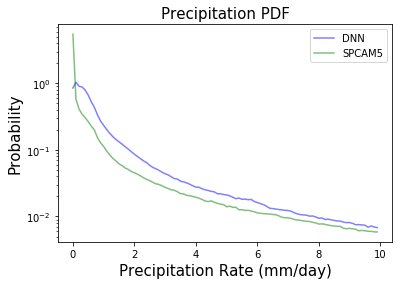

In [52]:
def pdf_gen(feat, targ, mini, maxi):
    maxi = 10.0
    shared_bins = np.histogram_bin_edges(feat, bins=100, range=(0, maxi))
    freq, edges = np.histogram(feat, bins = shared_bins, density = True)
    freq_targ, edges_targ = np.histogram(targ, bins = shared_bins, density = True)
    
    fig, ax = plt.subplots()
    plt.plot(edges[:-1], freq,  label = "DNN", alpha = 0.5, color = 'blue')
    plt.plot(edges_targ[:-1], freq_targ, label = "SPCAM5", alpha = 0.5, color = 'green')

    plt.xlabel('Precipitation Rate (mm/day)', fontsize = 15)
    plt.ylabel('Probability', fontsize = 15)
    plt.title('Precipitation PDF', fontsize = 15)
    plt.legend(loc = 'best')
    #plt.xscale('log')
    plt.yscale('log')
    
pdf_gen(p, t, m, M)

Multiply each bin by the value of the bin in order to get the amount distribtion, whcich can be more revealing of errors in the predictions 

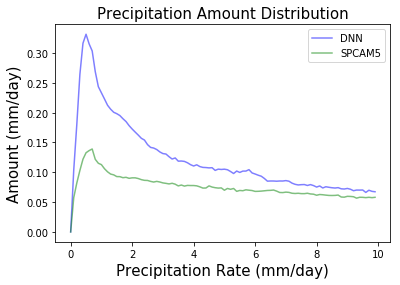

In [53]:
def amount_gen(feat, targ, mini, maxi):
    maxi = 10.0
    shared_bins = np.histogram_bin_edges(feat, bins=100, range=(0, maxi))
    freq, edges = np.histogram(feat, bins = shared_bins, density = True)
    freq_targ, edges_targ = np.histogram(targ, bins = shared_bins, density = True)
    
    totals = freq*edges[:-1]
    totals_targ = freq_targ*edges_targ[:-1]

    fig, ax = plt.subplots()
    
    plt.plot(edges[:-1], totals,  label = "DNN", alpha = 0.5, color = 'blue')
    plt.plot(edges_targ[:-1], totals_targ, label = "SPCAM5", alpha = 0.5, color = 'green')

    plt.xlabel('Precipitation Rate (mm/day)', fontsize = 15)
    plt.ylabel('Amount (mm/day)', fontsize = 15)
    plt.title('Precipitation Amount Distribution', fontsize = 15)
    plt.legend(loc = 'best')
    

amount_gen(p, t, m, M)